In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision 
from torchvision import datasets
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models
#from tqdm import tqdm_notebook as tqdm
import time
from tqdm import tqdm
import warnings
import copy
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from torchsummary import summary
from sklearn.metrics import accuracy_score,classification_report, f1_score,roc_auc_score

!pip install timm
#pre-trained models
import timm
#from efficientnet_pytorch import EfficientNet

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]

def printGPU():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  
printGPU()

Gen RAM Free: 8.2 GB  | Proc size: 3.7 GB
GPU RAM Free: 6643MB | Used: 4798MB | Util  42% | Total 11441MB


In [ ]:
!nvidia-smi

Tue Mar 29 15:56:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |   4798MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def images_transforms(phase):
    if phase == 'training':
        data_transformation =transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            #transforms.RandomEqualize(10),
            transforms.RandomRotation(degrees=(-20,20)),
            transforms.RandomHorizontalFlip(p=0.5),
            #transforms.CenterCrop(192),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        data_transformation=transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    
    return data_transformation

In [ ]:
class ResNet50(nn.Module):
    def __init__(self,num_class,pretrained_option=False):
        super(ResNet50,self).__init__()
        self.model=models.resnet152(pretrained=pretrained_option)
        
        if pretrained_option==True:
            for param in self.model.parameters():
                param.requires_grad=False

        num_neurons=self.model.fc.in_features
        self.model.fc= nn.Linear(num_neurons,num_class)
    def forward(self,X):
        out=self.model(X)
        return out

In [ ]:
class EfficientNet(nn.Module):
    def __init__(self,num_class,pretrained_option=False):
        super(EfficientNet,self).__init__()
        self.model=timm.create_model('tf_efficientnet_b4_ns',pretrained=True)
        
        if pretrained_option==True:
            for param in self.model.parameters():
                param.requires_grad=False
        
        num_neurons=self.model.classifier.in_features
        self.model.classifier=nn.Linear(num_neurons,num_class)
        
    def forward(self,X):
        out=self.model(X)
        return out

In [ ]:
def training(model, train_loader, test_loader, Loss, optimizer, epochs, device, num_class, name):
    model.to(device)
    best_model_wts = None
    best_evaluated_acc = 0
    train_acc = []
    test_acc = []
    test_Recall = []
    test_Precision = []
    test_F1_score = []
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer , gamma = 0.9)
    for epoch in range(1, epochs+1):
        with torch.set_grad_enabled(True):
            model.train()
            total_loss=0
            correct=0
            for idx,(data, label) in enumerate(tqdm(train_loader)):
                optimizer.zero_grad()
                        
                data = data.to(device,dtype=torch.float)
                label = label.to(device,dtype=torch.long)

                predict = model(data)      

                loss = Loss(predict, label.squeeze())

                total_loss += loss.item()
                pred = torch.max(predict,1).indices
                correct += pred.eq(label).cpu().sum().item()
                
                loss.backward()
                optimizer.step()

            total_loss /= len(train_loader.dataset)
            correct = (correct/len(train_loader.dataset))*100.
            print ("Epoch : " , epoch)
            print ("Loss : " , total_loss)
            print ("Correct : " , correct)
            #print(epoch, total_loss, correct)     
        scheduler.step()
        accuracy  , Recall , Precision , F1_score, _ = evaluate(model, device, test_loader)
        train_acc.append(correct)  
        test_acc.append(accuracy)
        test_Recall.append(Recall)
        test_Precision.append(Precision)
        test_F1_score.append(F1_score)

        if accuracy > best_evaluated_acc:
            best_evaluated_acc = accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
    #save model
    torch.save(best_model_wts, name+".pt")
    model.load_state_dict(best_model_wts)

    return train_acc , test_acc , test_Recall , test_Precision , test_F1_score

In [ ]:
def evaluate(model, device, test_loader):
    correct=0
    TP=0
    TN=0
    FP=0
    FN=0
    with torch.set_grad_enabled(False):
        model.eval()
        for idx,(data,label) in enumerate(test_loader):
            data = data.to(device,dtype=torch.float)
            label = label.to(device,dtype=torch.long)
            predict = model(data)
            pred = torch.max(predict,1).indices
            #correct += pred.eq(label).cpu().sum().item()
            for j in range(data.size()[0]):
                #print ("{} pred label: {} ,true label:{}" .format(len(pred),pred[j],int(label[j])))
                if (int (pred[j]) == int (label[j])):
                    correct +=1
                if (int (pred[j]) == 1 and int (label[j]) ==  1):
                    TP += 1
                if (int (pred[j]) == 0 and int (label[j]) ==  0):
                    TN += 1
                if (int (pred[j]) == 1 and int (label[j]) ==  0):
                    FP += 1
                if (int (pred[j]) == 0 and int (label[j]) ==  1):
                    FN += 1
        print ("TP : " , TP)
        print ("TN : " , TN)
        print ("FP : " , FP)
        print ("FN : " , FN)

        print ("num_correct :",correct ," / " , len(test_loader.dataset))
        Recall = TP/(TP+FN)
        print ("Recall : " ,  Recall )

        Precision = TP/(TP+FP)
        print ("Preecision : " ,  Precision )

        F1_score = 2 * Precision * Recall / (Precision + Recall)
        print ("F1 - score : " , F1_score)

        correct = (correct/len(test_loader.dataset))*100.
        print ("Accuracy : " , correct ,"%")

    return correct , Recall , Precision , F1_score, [[TN,FP],[FN,TP]]

In [ ]:
IMAGE_SIZE=(192,192)
batch_size=128
learning_rate = 0.01
epochs=16
num_classes=2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

train_path='/content/drive/MyDrive/chest_xray/train'
test_path='/content/drive/MyDrive/chest_xray/test'
val_path='/content/drive/MyDrive/chest_xray/val'

trainset=datasets.ImageFolder(train_path,transform=images_transforms('training'))
testset=datasets.ImageFolder(test_path,transform=images_transforms('test'))
valset=datasets.ImageFolder(val_path,transform=images_transforms('val'))

train_loader = DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
test_loader = DataLoader(testset,batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)

examples=iter(train_loader)
images,labels=examples.next()
print(images.shape)
# imshow(torchvision.utils.make_grid(images[:56],pad_value=20))

#model = torch.load('90_CNN_chest.pt')
#model = ResNet50(2, True)
model = EfficientNet(num_classes, True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# print (summary(model,(3,128,128)))

print (train_loader)
dataiter = iter(train_loader)
images , labels = dataiter.next()
print (type(images) , type(labels))
print (images.size(),labels.size())

Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_acc , test_acc , test_Recall , test_Precision , test_F1_score  = training(model, train_loader, test_loader, Loss, optimizer, epochs, device, num_classes, 'CNN_chest')

print("Best Result:")
accuracy  , Recall , Precision , F1_score, heatmap_data = evaluate(model, device, test_loader)

cuda
torch.Size([128, 3, 192, 192])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([128, 3, 192, 192]) torch.Size([128])


100%|██████████| 41/41 [01:48<00:00,  2.65s/it]

Epoch :  1
Loss :  0.0021621360205801065
Correct :  88.17451205510906


TP :  363
TN :  150
FP :  84
FN :  27
num_correct : 513  /  624
Recall :  0.9307692307692308
Preecision :  0.8120805369127517
F1 - score :  0.867383512544803
Accuracy :  82.21153846153845 %


100%|██████████| 41/41 [01:40<00:00,  2.46s/it]

Epoch :  2
Loss :  0.0017446491951418708
Correct :  91.5996938384998


TP :  322
TN :  188
FP :  46
FN :  68
num_correct : 510  /  624
Recall :  0.8256410256410256
Preecision :  0.875
F1 - score :  0.8496042216358839
Accuracy :  81.73076923076923 %


100%|██████████| 41/41 [01:40<00:00,  2.45s/it]

Epoch :  3
Loss :  0.0016060771225993313
Correct :  91.86758515116725


TP :  358
TN :  138
FP :  96
FN :  32
num_correct : 496  /  624
Recall :  0.9179487179487179
Preecision :  0.788546255506608
F1 - score :  0.8483412322274881
Accuracy :  79.48717948717949 %


100%|██████████| 41/41 [01:38<00:00,  2.41s/it]

Epoch :  4
Loss :  0.0015256839793302344
Correct :  92.53731343283582


TP :  356
TN :  145
FP :  89
FN :  34
num_correct : 501  /  624
Recall :  0.9128205128205128
Preecision :  0.8
F1 - score :  0.8526946107784431
Accuracy :  80.28846153846155 %


100%|██████████| 41/41 [01:40<00:00,  2.46s/it]

Epoch :  5
Loss :  0.0013539782795489086
Correct :  93.28358208955224


TP :  338
TN :  170
FP :  64
FN :  52
num_correct : 508  /  624
Recall :  0.8666666666666667
Preecision :  0.8407960199004975
F1 - score :  0.8535353535353535
Accuracy :  81.41025641025641 %


100%|██████████| 41/41 [01:38<00:00,  2.41s/it]

Epoch :  6
Loss :  0.0015362637310684115
Correct :  92.49904324531191


TP :  341
TN :  170
FP :  64
FN :  49
num_correct : 511  /  624
Recall :  0.8743589743589744
Preecision :  0.8419753086419753
F1 - score :  0.8578616352201258
Accuracy :  81.89102564102564 %


100%|██████████| 41/41 [01:39<00:00,  2.42s/it]

Epoch :  7
Loss :  0.0014541827304765634
Correct :  92.7860696517413


TP :  334
TN :  178
FP :  56
FN :  56
num_correct : 512  /  624
Recall :  0.8564102564102564
Preecision :  0.8564102564102564
F1 - score :  0.8564102564102564
Accuracy :  82.05128205128204 %


100%|██████████| 41/41 [01:40<00:00,  2.46s/it]

Epoch :  8
Loss :  0.0014546863503762694
Correct :  92.95828549559893


TP :  354
TN :  155
FP :  79
FN :  36
num_correct : 509  /  624
Recall :  0.9076923076923077
Preecision :  0.8175519630484989
F1 - score :  0.8602673147023085
Accuracy :  81.57051282051282 %


100%|██████████| 41/41 [01:39<00:00,  2.44s/it]

Epoch :  9
Loss :  0.0013331309291671348
Correct :  93.55147340221967


TP :  349
TN :  171
FP :  63
FN :  41
num_correct : 520  /  624
Recall :  0.8948717948717949
Preecision :  0.8470873786407767
F1 - score :  0.8703241895261846
Accuracy :  83.33333333333334 %


100%|██████████| 41/41 [01:37<00:00,  2.39s/it]

Epoch :  10
Loss :  0.00136920606587018
Correct :  92.86261002678913


TP :  346
TN :  169
FP :  65
FN :  44
num_correct : 515  /  624
Recall :  0.8871794871794871
Preecision :  0.8418491484184915
F1 - score :  0.863920099875156
Accuracy :  82.53205128205127 %


100%|██████████| 41/41 [01:39<00:00,  2.43s/it]

Epoch :  11
Loss :  0.0013581701678035362
Correct :  93.16877152698049


TP :  353
TN :  160
FP :  74
FN :  37
num_correct : 513  /  624
Recall :  0.9051282051282051
Preecision :  0.8266978922716628
F1 - score :  0.8641370869033048
Accuracy :  82.21153846153845 %


100%|██████████| 41/41 [01:37<00:00,  2.39s/it]

Epoch :  12
Loss :  0.001318447998986133
Correct :  93.36012246460008


TP :  356
TN :  153
FP :  81
FN :  34
num_correct : 509  /  624
Recall :  0.9128205128205128
Preecision :  0.8146453089244852
F1 - score :  0.8609431680773882
Accuracy :  81.57051282051282 %


100%|██████████| 41/41 [01:38<00:00,  2.40s/it]

Epoch :  13
Loss :  0.0013136753090327606
Correct :  93.24531190202832


TP :  352
TN :  163
FP :  71
FN :  38
num_correct : 515  /  624
Recall :  0.9025641025641026
Preecision :  0.8321513002364066
F1 - score :  0.8659286592865928
Accuracy :  82.53205128205127 %


100%|██████████| 41/41 [01:36<00:00,  2.34s/it]

Epoch :  14
Loss :  0.0012936386291523615
Correct :  93.36012246460008


TP :  351
TN :  158
FP :  76
FN :  39
num_correct : 509  /  624
Recall :  0.9
Preecision :  0.8220140515222483
F1 - score :  0.8592411260709913
Accuracy :  81.57051282051282 %


100%|██████████| 41/41 [01:36<00:00,  2.35s/it]

Epoch :  15
Loss :  0.001328910819664341
Correct :  93.51320321469575


TP :  355
TN :  156
FP :  78
FN :  35
num_correct : 511  /  624
Recall :  0.9102564102564102
Preecision :  0.8198614318706697
F1 - score :  0.8626974483596598
Accuracy :  81.89102564102564 %


100%|██████████| 41/41 [01:36<00:00,  2.35s/it]

Epoch :  16
Loss :  0.001267462746420903
Correct :  93.7236892460773


TP :  350
TN :  164
FP :  70
FN :  40
num_correct : 514  /  624
Recall :  0.8974358974358975
Preecision :  0.8333333333333334
F1 - score :  0.8641975308641975
Accuracy :  82.37179487179486 %
Best Result:
TP :  349
TN :  171
FP :  63
FN :  41
num_correct : 520  /  624
Recall :  0.8948717948717949
Preecision :  0.8470873786407767
F1 - score :  0.8703241895261846
Accuracy :  83.33333333333334 %


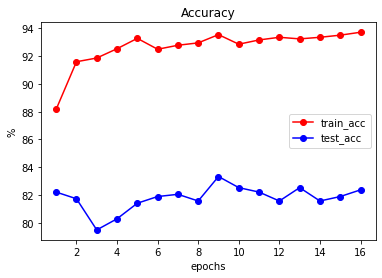

In [ ]:
x_axis = [i for i in range(1,1+epochs)]
plt.title("Accuracy") # title
plt.ylabel("%") # y label
plt.xlabel("epochs") # x label
plt.plot(x_axis, train_acc, color = 'red', marker = 'o', label = 'train_acc')
plt.plot(x_axis, test_acc, color = 'blue', marker = 'o', label = 'test_acc')
plt.legend()
plt.show()

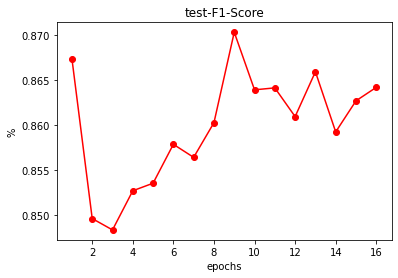

In [ ]:
plt.title("test-F1-Score") # title
plt.ylabel("%") # y label
plt.xlabel("epochs") # x label
plt.plot(x_axis, test_F1_score, color = 'red', marker = 'o', label = 'train_acc')
plt.show()

Text(33.0, 0.5, 'Prediction')

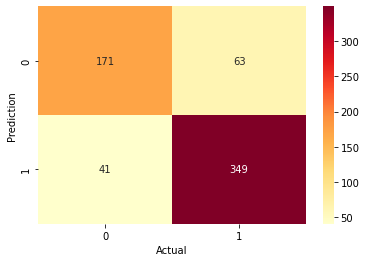

In [ ]:
sns.heatmap(heatmap_data, annot = True, cmap = 'YlOrRd', fmt='.3g')
plt.xlabel('Actual') 
plt.ylabel('Prediction') 

In [ ]:
!pip install timm

In [ ]:
def saliency(model):
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    
    examples=iter(test_loader)
    images,labels=examples.next()
    input = images[:1]
    input = input.to(device,dtype=torch.float)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.cpu().numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


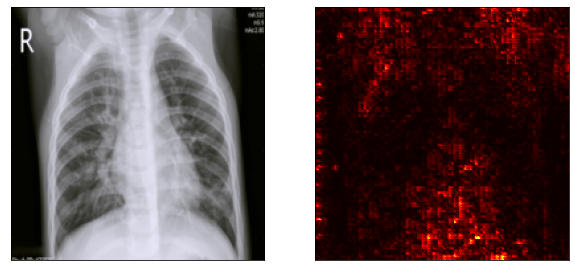

In [ ]:
saliency(model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


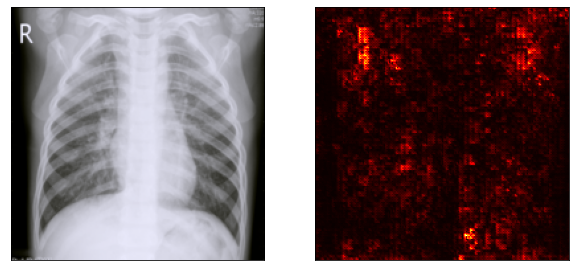

In [ ]:
saliency(model)